# Multi-Word Relevant Expressions LocalMaxs Extractor

From: "A Local Maxima method and a Fair Dispersion Normalization for extracting multi-word units from corpora":

"The availability of **multi-word units (MWUs)** in NLP lexica has important applications:
- enhances parsing precision, 
- helps on attachment decision
- enables more natural interaction of non-specialists users with information retrieval engines"

"Most statistical approaches to MWUs extraction from corpora:
1. measure the association between two words
2. define thresholds for deciding which bigrams may be elected as possible units and
3. use complex linguistic filters and language specific morpho-syntactic rules for filtering those units."


Relevant Expressions:: features with high value

"Thus, more generally, multiword features consist of x number of words occurring within a maximum window size of y (with y ≥ x naturally)." (Weiss2005_Book_TextMining.pdf)

**Local Maxs Algorithm"**:
LocalMaxs Algorithm (Silva & Lopes,99)
Core idea: words combine preferably with limited sets of words, forming cohesion groups. An n‐gram arises as Relevant Expression when its cohesion stands out in the context of its neighborhood.

(From slides)

## Implementation
> Implement the multi-word Relevant Expressions LocalMaxs extractor, taking into account the following requirements:

> a) To obtain tokens, you may add a space character before and/or after characters such as “;”, “:”, “!”, “?”, “<”, “>”, “&”, “)”, “(“, “]”, “[“, among others that do not change the semantics of the text, in order to improve the reliability of token frequencies.

In [1]:
SPECIAL_CHARACTERS = [';', '.', ':', '!', '?', '<', '>',
                      '&', '(', ')', '[', ']', '\n', ',',
                      '}', '{', "'", '"', '-', '\\', '/',
                      '+', '=', '~', '@', '`', '%', '#',
                      '£', '$', '^', '*', '_', '‘', '’']

As special characters which we consider as individual tokens we chose:
```
~	Tilde.
`	Acute, backquote, backtick, grave, grave accent, left quote, open quote, or a push.
!	Exclamation mark, exclamation point, or bang.
@	Ampersat, arobase, asperand, at, or at symbol.
#	Octothorpe, number, pound, sharp, or hash.
$	Dollar sign or generic currency.
%	Percent.
^	Caret or circumflex.
&	Ampersand, epershand, or and symbol.
*	Asterisk, mathematical multiplication symbol, and sometimes referred to as a star.
(	Open or left parenthesis.
)	Close or right parenthesis.
-	Hyphen, minus, or dash.
_	Underscore.
+	Plus.
=	Equal.
{	Open brace, squiggly brackets, or curly bracket.
}	Close brace, squiggly brackets, or curly bracket.
[	Open bracket.
]	Closed bracket.
|	Pipe, or, or vertical bar.
\	Backslash or reverse solidus.
/	Forward slash, solidus, virgule, whack, and mathematical division symbol.
:	Colon.
;	Semicolon.
"	Quote, quotation mark, or inverted commas.
'	Apostrophe or single quote.
<	Less than or angle brackets.
>	Greater than or angle brackets.
,	Comma.
.	Period, dot, or full stop.
?	Question mark.
```

### Load Corpus
Load corpus document into dict with split tokens for each document. This datastructure choice allows for later calculating document specific measures, such as e.g. *Tf_Idf*.

In [2]:
def separate_special_tokens(string):
    for char in SPECIAL_CHARACTERS:
        string = string.replace(char, f" {char} ")
    return string

In [3]:
# Test separate_special_tokens
a = "&b!ld"
#print(separate_special_tokens(a))

In [4]:
def tokenize(string):
    tokens = separate_special_tokens(string).lower().split(' ')
    # don't return empty strings
    return tuple(filter(None, tokens))

In [5]:
from pathlib import Path
from collections import defaultdict
import os
CORPUS_PATH = "./corpus4mw"
CORPUS_NAME = 'corpus4mw'

corpus = defaultdict(tuple)

# open all files starting with "fil" in corpus path
for doc_path in Path(CORPUS_PATH).glob('fil_*'):
    
    # read whole document and strip new lines
    doc = Path(doc_path).read_text().replace('\n', '')
    # standardize space characters
    doc = doc.replace(u'\xa0', u' ').replace(u'\u3000', u' ').replace(u'\u2009', u' ')
    
    doc_name = os.path.basename(doc_path)
    corpus[doc_name] = tokenize(doc)

corpus_words = [word for doc_list in corpus.values() for word in doc_list]
corpus_size = len(corpus_words)

In [6]:
#corpus

## Calculate Corpus N-Gram Frequency Dictionary 

Calculate and store n_gram absolute and relative frequencies

In [7]:
def calculate_absolute_n_gram_frequencies(corpus, n_gram_size):
    n_gram_freqs = defaultdict(lambda: defaultdict(float))
    for doc_name, doc in corpus.items():
        for i in range(len(doc) - n_gram_size):
            n_gram = doc[i: i + n_gram_size]
            n_gram_freqs[n_gram]["abs_freq"] += 1
    return n_gram_freqs

In [8]:
def calculate_n_gram_frequencies(corpus, max_n_gram_size, corpus_size):
    n_gram_frequencies = dict()
    for n_gram_size in range(1, max_n_gram_size + 1):
        n_gram_frequencies[n_gram_size] = calculate_absolute_n_gram_frequencies(corpus, n_gram_size)
        for freq in n_gram_frequencies[n_gram_size].values():
            freq["rel_freq"] = freq["abs_freq"] / corpus_size
    return n_gram_frequencies

In [9]:
MAX_N_GRAM_SIZE = 8

# dict storing abs. and relative frequency for all n-grams in corpus 
# one dict per n-gram size
# we store n-grams as tuples

# n_gram_freq: {
#     '1': {
#         ('starship'): {
#             'abs_freq': 1000,
#             'rel_freq': 0.0001
#         },
#         ('jedi'): {...}
#     },
#     '2': {
#         ('jedi', 'knight'): {
#             'abs_freq': 500,
#             'rel_freq': 0.00005
#         },
#         ...
#     },
#     ...
# }

#n_gram_freq = calculate_n_gram_frequencies(corpus, MAX_N_GRAM_SIZE, corpus_size)

### Pre filtering obtained n-grams

In [10]:
def minimum_frequency_filter(n_gram_freq_dict, min_freq):
    filtered_n_gram_freq_dict = dict()
    for n_gram_size in n_gram_freq_dict:
        filtered_n_gram_freq_dict[n_gram_size] = defaultdict(lambda: defaultdict(float))
        for n_gram, n_gram_freq in n_gram_freq_dict[n_gram_size].items():
            if n_gram_freq["abs_freq"] >= min_freq:
                filtered_n_gram_freq_dict[n_gram_size][n_gram] = n_gram_freq_dict[n_gram_size][n_gram]
    return filtered_n_gram_freq_dict

In [11]:
def special_characters_filter(n_gram_freq_dict, special_characters):
    filtered_n_gram_freq_dict = dict()
    for n_gram_size in n_gram_freq_dict:
        filtered_n_gram_freq_dict[n_gram_size] = defaultdict(lambda: defaultdict(float))
        for n_gram, n_gram_freq in n_gram_freq_dict[n_gram_size].items():
            if not any(sc for sc in special_characters if sc in n_gram):
                filtered_n_gram_freq_dict[n_gram_size][n_gram] = n_gram_freq_dict[n_gram_size][n_gram]
    return filtered_n_gram_freq_dict

## Cohesion Metrics Implementation

> c) Let it be possible to use more than one cohesion metric, such as SCP, Dice, φ2, amomg others.

Cohesion metrics:
- SCP: 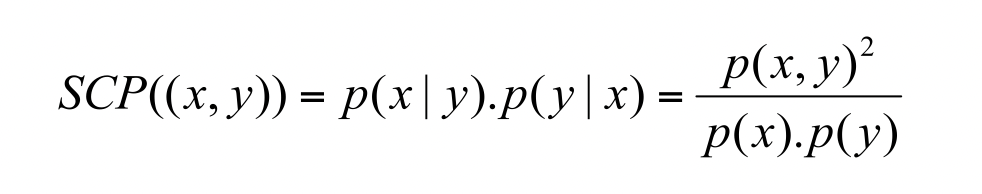
    - $scp(n) \in [0,1]$
- Dice: 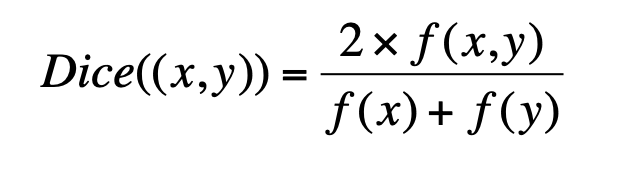
    - $dice(n) \in [0,1]$
- MI: 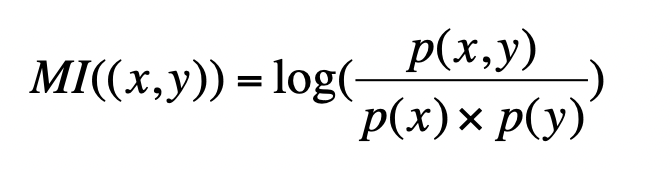
    - $MI(n) [0, \infty]$

For multi-word n-grams:
    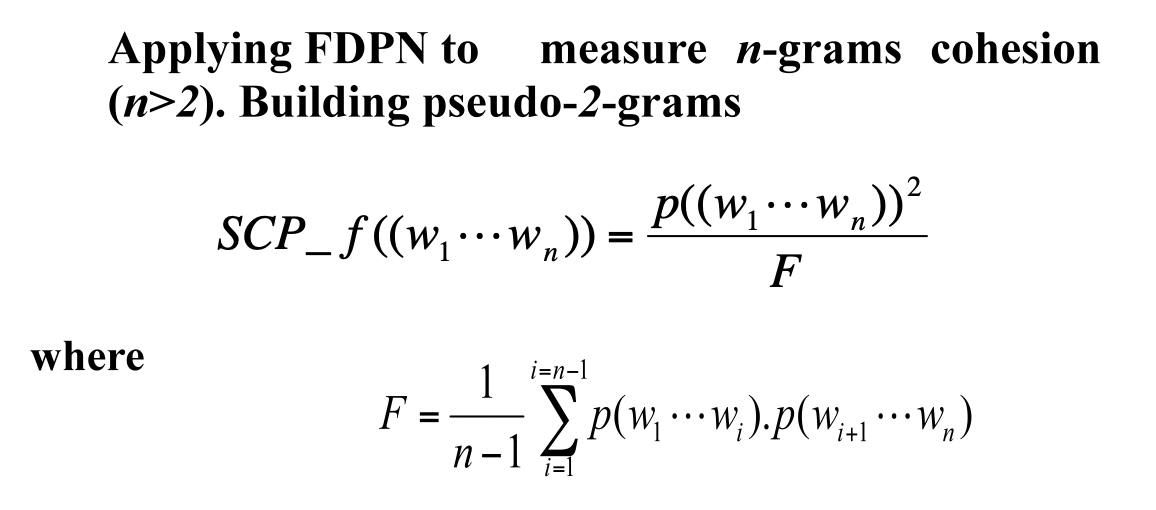

In [12]:
def calculate_absolute_frequency_of_n_gram(n_gram, n_gram_freq_dict):
    return n_gram_freq_dict[len(n_gram)][n_gram]['abs_freq']

In [13]:
def calculate_relative_frequency_of_n_gram(n_gram, n_gram_freq_dict):
    return n_gram_freq_dict[len(n_gram)][n_gram]['rel_freq']

In [14]:
def lower_case_tuple(l):
    return tuple(item.lower() for item in l)

In [15]:
def scp_f(n_gram, n_gram_freq_dict):
    n_gram = lower_case_tuple(n_gram)
    if len(n_gram) == 1:
        #scp_f for unigrams is always 1 / not defined
        return 1
    p_squared = calculate_relative_frequency_of_n_gram(n_gram, n_gram_freq_dict)**2
    sum_relative_freq = 0
    for i in range(0,len(n_gram)-1):
        p = calculate_relative_frequency_of_n_gram(n_gram[:i+1], n_gram_freq_dict) * calculate_relative_frequency_of_n_gram(n_gram[i+1:], n_gram_freq_dict)
        sum_relative_freq = sum_relative_freq + p
    F = 1 / (len(n_gram) - 1) * sum_relative_freq
    if (F == 0):
        print(n_gram)
    scp_f = p_squared / F
    return scp_f

In [16]:
def dice_f(n_gram, n_gram_freq_dict):
    n_gram = lower_case_tuple(n_gram)
    abs_frequency = calculate_absolute_frequency_of_n_gram(n_gram, n_gram_freq_dict)
    sum_abs_freq = 0
    for i in range(0,len(n_gram)-1):
        f = calculate_absolute_frequency_of_n_gram(n_gram[:i+1], n_gram_freq_dict) * calculate_absolute_frequency_of_n_gram(n_gram[i+1:], n_gram_freq_dict)
        sum_abs_freq = sum_abs_freq + f
    F = 1 / (len(n_gram) - 1) * sum_abs_freq
    dice = (abs_frequency * 2) / F
    return dice

In [17]:
import math
def mi_f(n_gram, n_gram_freq_dict):
    n_gram = lower_case_tuple(n_gram)
    relative_frequency = calculate_relative_frequency_of_n_gram(n_gram, n_gram_freq_dict)
    sum_relative_freq = 0
    for i in range(0,len(n_gram)-1):
        p = calculate_relative_frequency_of_n_gram(n_gram[:i+1], n_gram_freq_dict) * calculate_relative_frequency_of_n_gram(n_gram[i+1:], n_gram_freq_dict)
        sum_relative_freq = sum_relative_freq + p
    F = 1 / (len(n_gram) - 1) * sum_relative_freq
    mi = math.log(relative_frequency / F)
    return mi

In [18]:
# check metrics

In [19]:
# print('SCP_f:', scp_f(('United', 'States', 'of', 'America'), n_gram_freq))
# print('Dice_f:', dice_f(('United', 'States', 'of', 'America'), n_gram_freq))
# print('MI_f:', mi_f(('United', 'States', 'of', 'America'), n_gram_freq))

check plausibility of SCP_f:

In [20]:
# calculate ['United', 'States'] by hand
# p_squared = n_gram_freq[2][('united', 'states')]['rel_freq']**2

# p_united = n_gram_freq[1][('united',)]['rel_freq']

# p_states = n_gram_freq[1][('states',)]['rel_freq']


# scp_united_states = p_squared / (p_united * p_states)
# print(scp_united_states)

# print(scp_f(('united', 'states'), n_gram_freq))

## Local Max Implementation

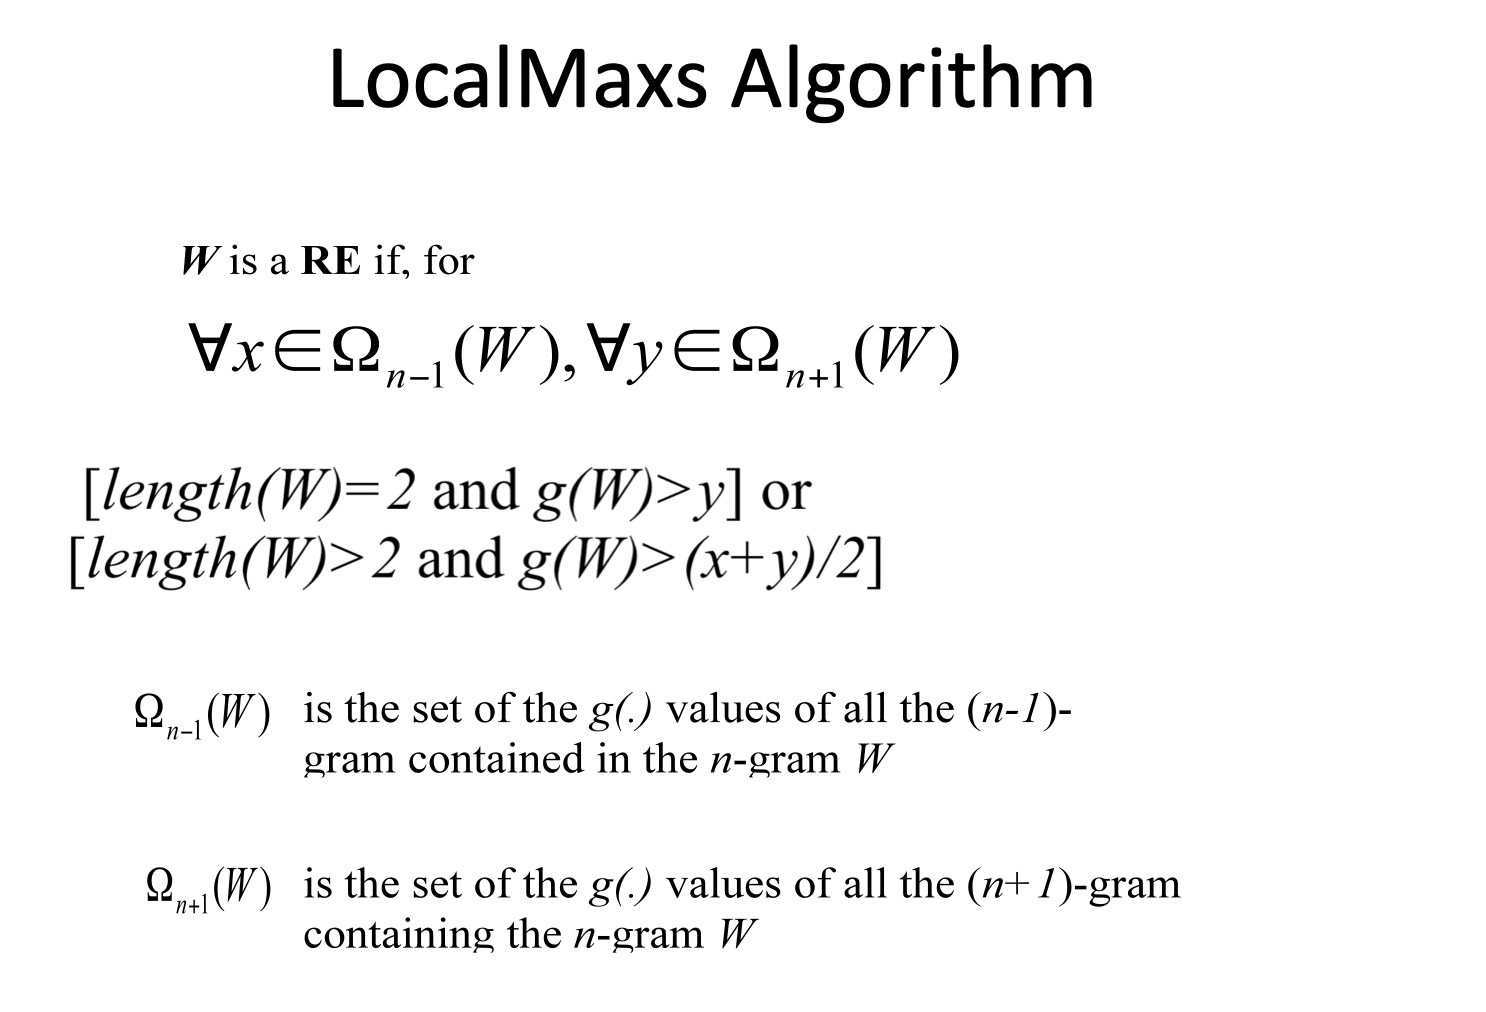

Calculate containing and contained n-grams. (Based on unique list of n-grams in n_gram_freq keys to reduce calculation overhead.)

In [21]:
def calculate_containing_and_contained_n_grams(n_gram_freq_dict, max_n_gram_size):
    containing_n_grams = defaultdict(list)
    contained_n_grams = defaultdict(list)
    
    # we don't calculate contained n-grams for unigrams
    for n_gram_size in range(2, MAX_N_GRAM_SIZE + 1):
        for n_gram in n_gram_freq_dict[n_gram_size]:

            # calculate contained n-grams
            left_contained_n_gram = n_gram[0: -1]
            right_contained_n_gram = n_gram[1:]

            contained_n_grams[n_gram] = [left_contained_n_gram, right_contained_n_gram]
            containing_n_grams[left_contained_n_gram].append(n_gram)
            containing_n_grams[right_contained_n_gram].append(n_gram)
    
    return containing_n_grams, contained_n_grams

In [22]:
import itertools 

def calculate_local_max_fixed_size(re_size, n_gram_freq_dict, containing_n_grams_dict, contained_n_grams_dict, glue):
    relevant_expressions = []
    
    if re_size == 2:
        for n_gram in n_gram_freq_dict[re_size]:
            
            containing_n_grams = containing_n_grams_dict[n_gram]
            containing_n_grams_glues = [glue(containing_n_gram, n_gram_freq_dict) for containing_n_gram in containing_n_grams]
            n_gram_glue = glue(n_gram, n_gram_freq_dict)
            
            if all([n_gram_glue > containing_n_gram_glue for containing_n_gram_glue in containing_n_grams_glues]):
                relevant_expressions.append(n_gram)
            
    else:
        for n_gram in n_gram_freq_dict[re_size]:
            
            containing_n_grams = containing_n_grams_dict[n_gram]
            containing_n_grams_glues = [glue(containing_n_gram, n_gram_freq_dict) for containing_n_gram in containing_n_grams]
            
            # contained n_grams 
            contained_n_grams = contained_n_grams_dict[n_gram]
            contained_n_grams_glues = [glue(contained_n_gram, n_gram_freq_dict) for contained_n_gram in contained_n_grams]
            
            n_gram_glue = glue(n_gram, n_gram_freq_dict)
            
            if all(n_gram_glue > ((glues[0] + glues[1]) / 2) for glues in itertools.product(contained_n_grams_glues, containing_n_grams_glues)):
                relevant_expressions.append(n_gram)
        
    return relevant_expressions

In [23]:
def local_max(corpus, max_re_size, n_gram_freq_dict, glue):
    # extract all relevant expressions of sizes up to max_re_size (inclusive) from corpus using glue function
    relevant_expressions = []
    
    containing_n_grams, contained_n_grams = calculate_containing_and_contained_n_grams(n_gram_freq_dict, max_re_size + 1)
    
    # local max is only defined for multi-grams
    for re_size in range(2, max_re_size + 1):
        relevant_expressions += calculate_local_max_fixed_size(re_size, n_gram_freq_dict, containing_n_grams, contained_n_grams, glue)
    
    return relevant_expressions

#### Example relevant expression extraction with local max

In [24]:
# max_re_size = 7

# n_gram_freq_dict = calculate_n_gram_frequencies(corpus, max_re_size + 1, corpus_size)

# filtered_n_gram_freq_dict = minimum_frequency_filter(n_gram_freq_dict, 2)
# filtered_n_gram_freq_dict = special_characters_filter(filtered_n_gram_freq_dict, SPECIAL_CHARACTERS)

# re_7 = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, scp_f)

## Stop Words Filter Implementation

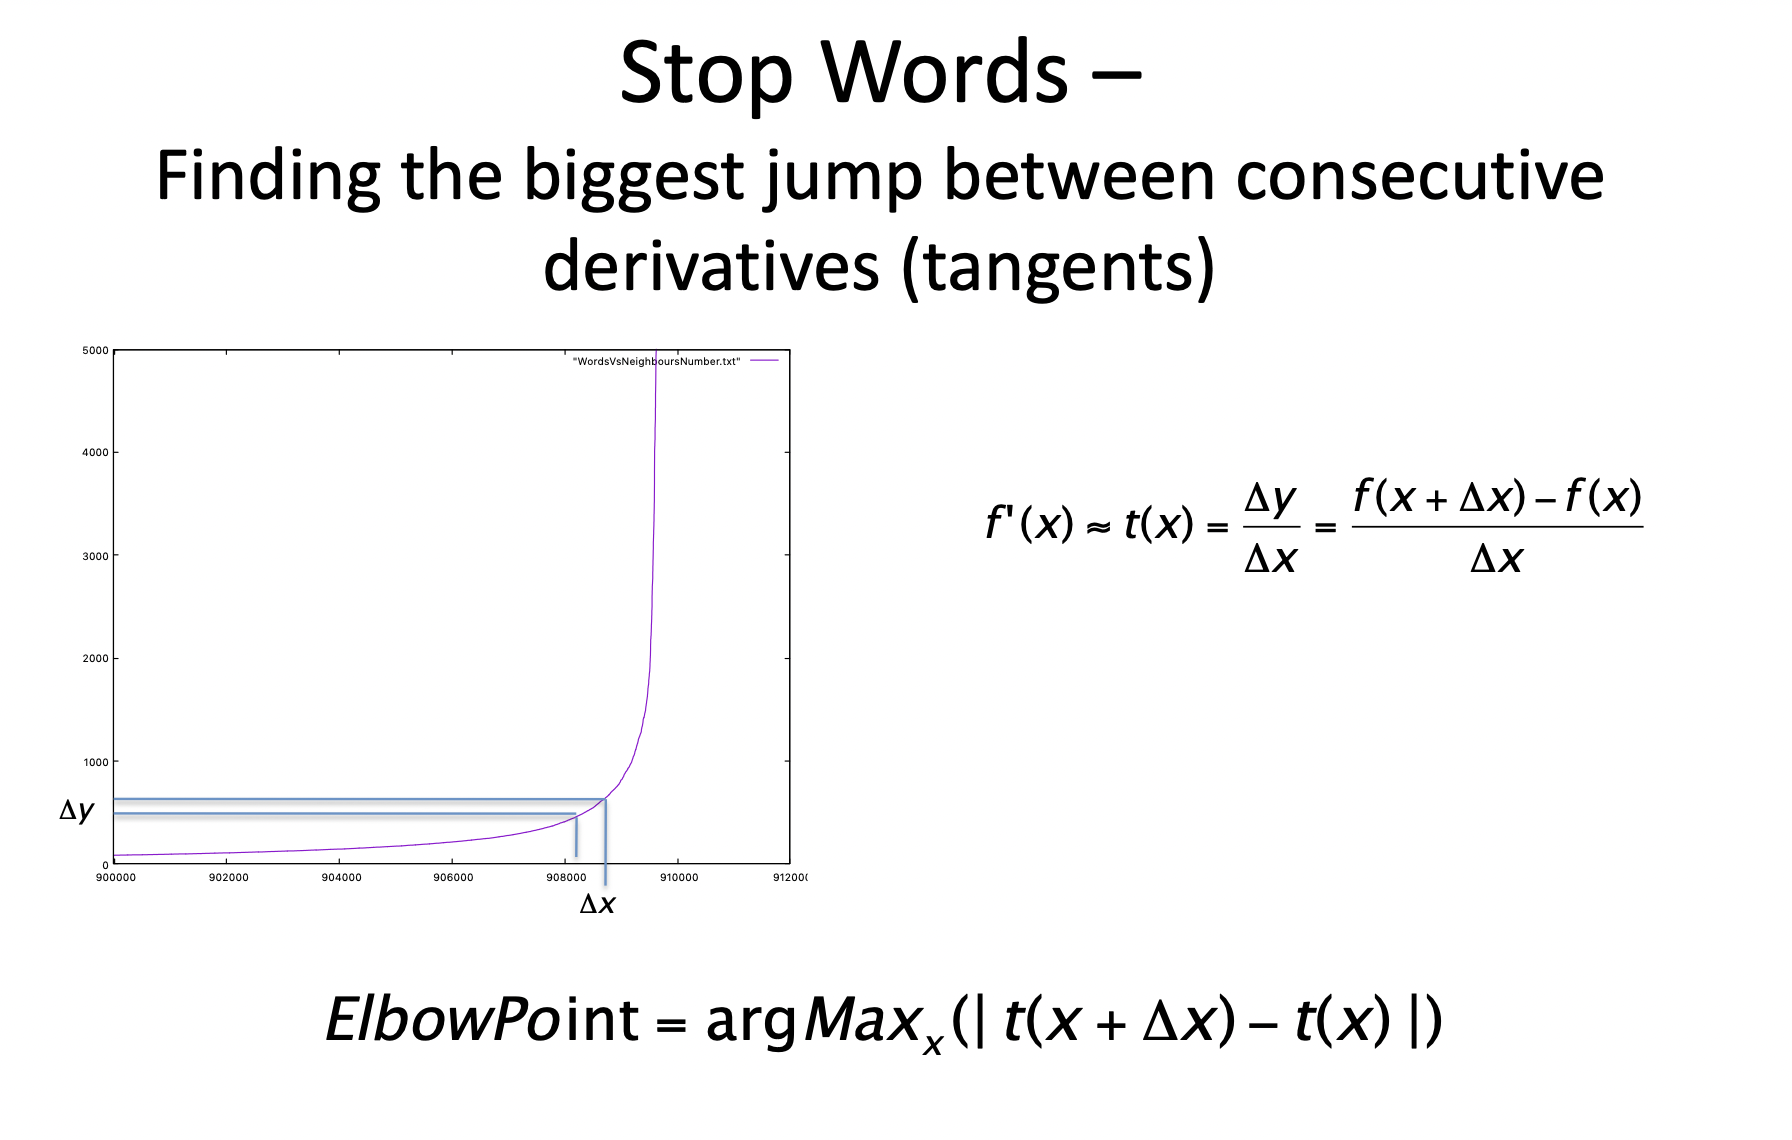

In [25]:
import math
def stop_words_filter(corpus, n_gram_freq_dict, relevant_expressions):
    #corpus_words = set(word for doc_list in corpus.values() for word in doc_list)
    
    neighbour_dict = defaultdict(set)
    
    for doc_name, doc in corpus.items():
        for word_index in range(0, len(doc)):
            
            word = doc[word_index]
            
            if word_index != 0:
                right_neighbour = doc[word_index - 1]
                neighbour_dict[word].add(right_neighbour)
            if word_index != len(doc) - 1:
                left_neighbour = doc[word_index + 1]
                neighbour_dict[word].add(left_neighbour)
            
    neighbour_counts = []
    
    for word, neighbours in neighbour_dict.items():
        neighbour_counts.append((len(neighbours), word))
        
    neighbour_counts.sort(reverse=True)
    
    # find elbow point
    elbow_point_index = 0
    max_tangens = 0
    for index in range(0, len(neighbour_counts) - 1):
        cur_neighbour_count = neighbour_counts[index][0]
        next_neighbour_count = neighbour_counts[index + 1][0]
        neighbour_diff = cur_neighbour_count - next_neighbour_count #list is sorted decreasing
        tangens_diff = abs(math.tan(cur_neighbour_count + neighbour_diff) - math.tan(cur_neighbour_count))
        
        if tangens_diff > max_tangens:
            elbow_point_index = index
            max_tangens = tangens_diff
    
    stop_word_counts = neighbour_counts[: elbow_point_index + 1]
    
    stop_words = [stop_word_count[1] for stop_word_count in stop_word_counts]
    
    filtered_relevant_expressions = []
    for re in relevant_expressions:
        if re[0] in stop_words or re[-1] in stop_words:
            continue
        filtered_relevant_expressions.append(re)
    
    return stop_words, filtered_relevant_expressions

### Extract to Files

In [26]:
import os
import random

In [27]:
print(CORPUS_NAME)

corpus4mw


In [28]:
max_re_size = 7

n_gram_freq_dict = calculate_n_gram_frequencies(corpus, max_re_size + 1, corpus_size)

### Evaluate Distribution of N-Grams in Corpus

In [29]:
with open(os.path.join(f"./results/{CORPUS_NAME}/n_gram_distribution.txt"), 'w') as f:
        for freq in n_gram_freq_dict:
            f.write(f"{freq}: {len(n_gram_freq_dict[freq])} \n")

### Apply special character filter

In [30]:
filtered_n_gram_freq_dict = special_characters_filter(n_gram_freq_dict, SPECIAL_CHARACTERS)

### Calculate Local Max REs and write to files

In [31]:
def write_res_to_file(results_directory, filename, res):
    with open(os.path.join(results_directory, filename), 'w') as f:
        for re in res:
            f.write(f"{ ' '.join(re) }\n")

In [32]:
def calc_avg_extracted_re_occurence(res, n_gram_freq_dict):
    occurence_sum = 0
    for re in res:
        occurence_sum += n_gram_freq_dict[len(re)][re]['abs_freq']
    return occurence_sum / len(res)

In [33]:
def write_statistics_to_file(results_directory, filename, statistics):
    with open(os.path.join(results_directory, filename), 'w') as f:
        for stat_name, stat in statistics.items():
            f.write(f"{stat_name}: {stat}\n")

#### Baseline: Relevant Expressions with Local-Max with Frequency Filter = 2 and Special Character Filter

In [34]:
def calculate_and_write_base_line_results(corpus, corpus_name, max_re_size, n_gram_freq_dict):
    statistics = dict()
    results_directory = f"./results/{corpus_name}/baseline_local_max/"
    
    filtered_n_gram_freq_dict = minimum_frequency_filter(n_gram_freq_dict, 2)
    
    #extract and write all res and randomly selected res for each type of glue
    re_scp = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, scp_f)
    re_dice = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, dice_f)
    re_mi = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, mi_f)
    
    write_res_to_file(results_directory, 'res_baseline_scp_all.txt', re_scp)
    write_res_to_file(results_directory, 'res_baseline_dice_all.txt', re_dice)
    write_res_to_file(results_directory, 'res_baseline_mi_all.txt', re_mi)
    
    write_res_to_file(results_directory, 'res_baseline_scp_sample.txt', random.sample(re_scp, 200))
    write_res_to_file(results_directory, 'res_baseline_dice_sample.txt', random.sample(re_dice, 200))
    write_res_to_file(results_directory, 'res_baseline_mi_sample.txt', random.sample(re_mi, 200))
    
    #calc statistics
    statistics['num_re_scp_baseline'] = len(re_scp)
    statistics['num_re_dice_baseline'] = len(re_dice)
    statistics['num_re_mi_baseline'] = len(re_mi)
    
    statistics['avg_occur_re_scp_baseline'] = calc_avg_extracted_re_occurence(re_scp, filtered_n_gram_freq_dict)
    statistics['avg_occur_re_dice_baseline'] = calc_avg_extracted_re_occurence(re_dice, filtered_n_gram_freq_dict)
    statistics['avg_occur_re_mi_baseline'] = calc_avg_extracted_re_occurence(re_mi, filtered_n_gram_freq_dict)
    
    write_statistics_to_file(results_directory, 'statistics.txt', statistics)

#### Relevant Expressions with Local-Max with Frequency Filter = 5 and Special Character Filter

In [35]:
def calculate_and_write_freq_bigger_5_results(corpus,corpus_name, max_re_size, n_gram_freq_dict):
    statistics = dict()
    results_directory = f"./results/{corpus_name}/local_max_freq_bigger_5/"
    
    filtered_n_gram_freq_dict = minimum_frequency_filter(n_gram_freq_dict, 5)
    
    #extract and write all res and randomly selected res for each type of glue
    re_scp = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, scp_f)
    re_dice = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, dice_f)
    re_mi = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, mi_f)
    
    write_res_to_file(results_directory, 'res_freq_bigger_5_scp_all.txt', re_scp)
    write_res_to_file(results_directory, 'res_freq_bigger_5_dice_all.txt', re_dice)
    write_res_to_file(results_directory, 'res_freq_bigger_5_mi_all.txt', re_mi)
    
    write_res_to_file(results_directory, 'res_freq_bigger_5_scp_sample.txt', random.sample(re_scp, 200))
    write_res_to_file(results_directory, 'res_freq_bigger_5_dice_sample.txt', random.sample(re_dice, 200))
    write_res_to_file(results_directory, 'res_freq_bigger_5_mi_sample.txt', random.sample(re_mi, 200))
    
    #calc statistics
    statistics['num_re_scp_freq_5'] = len(re_scp)
    statistics['num_re_dice_freq_5'] = len(re_dice)
    statistics['num_re_mi_freq_5'] = len(re_mi)
    
    statistics['avg_occur_re_scp_freq_5'] = calc_avg_extracted_re_occurence(re_scp, filtered_n_gram_freq_dict)
    statistics['avg_occur_re_dice_freq_5'] = calc_avg_extracted_re_occurence(re_dice, filtered_n_gram_freq_dict)
    statistics['avg_occur_re_mi_freq_5'] = calc_avg_extracted_re_occurence(re_mi, filtered_n_gram_freq_dict)
    
    write_statistics_to_file(results_directory, 'statistics.txt', statistics)

#### Relevant Expressions with Local-Max with Frequency Filter = 2 and Stop Words Filter

In [36]:
def calculate_and_write_stop_words_results(corpus, corpus_name, max_re_size, n_gram_freq_dict):
    statistics = dict()
    results_directory = f"./results/{corpus_name}/local_max_stop_words/"
    
    filtered_n_gram_freq_dict = minimum_frequency_filter(n_gram_freq_dict, 2)
    
    re_scp = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, scp_f)
    re_dice = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, dice_f)
    re_mi = local_max(corpus, max_re_size, filtered_n_gram_freq_dict, mi_f)
    
    stop_words, filtered_res_scp = stop_words_filter(corpus, filtered_n_gram_freq_dict, re_scp)
    stop_words, filtered_res_dice = stop_words_filter(corpus, filtered_n_gram_freq_dict, re_dice)
    stop_words, filtered_res_mi = stop_words_filter(corpus, filtered_n_gram_freq_dict, re_mi)
    
    write_res_to_file(results_directory, 'res_stop_words_scp_all.txt', filtered_res_scp)
    write_res_to_file(results_directory, 'res_stop_words_dice_all.txt', filtered_res_dice)
    write_res_to_file(results_directory, 'res_stop_words_mi_all.txt', filtered_res_mi)
    
    write_res_to_file(results_directory, 'res_stop_words_scp_sample.txt', random.sample(filtered_res_scp, 200))
    write_res_to_file(results_directory, 'res_stop_words_dice_sample.txt', random.sample(filtered_res_dice, 200))
    write_res_to_file(results_directory, 'res_stop_words_mi_sample.txt', random.sample(filtered_res_mi, 200))
    
    #calc statistics
    statistics['num_re_scp_stop_words'] = len(re_scp)
    statistics['num_re_dice_stop_words'] = len(re_dice)
    statistics['num_re_mi_stop_words'] = len(re_mi)
    
    statistics['avg_occur_re_scp_stop_words'] = calc_avg_extracted_re_occurence(filtered_res_scp, filtered_n_gram_freq_dict)
    statistics['avg_occur_re_dice_stop_words'] = calc_avg_extracted_re_occurence(filtered_res_dice, filtered_n_gram_freq_dict)
    statistics['avg_occur_re_mi_stop_words'] = calc_avg_extracted_re_occurence(filtered_res_mi, filtered_n_gram_freq_dict)
    
    write_statistics_to_file(results_directory, 'statistics.txt', statistics)

In [37]:
calculate_and_write_base_line_results(corpus, CORPUS_NAME, max_re_size, filtered_n_gram_freq_dict)

In [38]:
calculate_and_write_freq_bigger_5_results(corpus, CORPUS_NAME, max_re_size, filtered_n_gram_freq_dict)

In [39]:
calculate_and_write_stop_words_results(corpus, CORPUS_NAME, max_re_size, filtered_n_gram_freq_dict)